# Solving the Reacher environment with DDPG and Population Based Training

---

Below we use reinforcement learning methods to solve a version of the Reacher environment.

### 1. Start the Environment

Everything below assumes you have installed the project's dependencies successfully. See [the readme](Readme.md) for instructions.

We load the environment and select a mode without graphics. If you want to see an agent in action, edit this so that you don't pass the `no_graphics` option. If you are not on 64-bit Windows, you will need to download the appropriate Unity environment package, check where it stores the environment program, and adjust the environment path accordingly.

In [1]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='data/Reacher_Windows_x86_64/Reacher.exe')
env = UnityEnvironment(file_name='data/Reacher_Windows_x86_64/Reacher.exe', no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

We can run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

Let's make sure we have understood correctly how to interface with the environment by taking random actions in it. We can also find out how many time steps an episode takes (we assume they are all the same length in this environment because we don't notice anything that would end an episode premature in the environment description).

In [4]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
time = 0
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    time += 1
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))
print(time)

Total score (averaged over agents) this episode: 0.5099999886006117
1001


### 4. Learning to act in the reacher environment with DDPG and Population Based Training

We will use the [Deep Deterministic Policy Gradient (DDPG) algorithm](https://arxiv.org/abs/1509.02971) (Lillicrap et al, 2016) to attempt to learn to act in the environment described in the `README.md`.

The DDPG algorithm is an actor critic algorithm for updating an actor-network (an artificial neural network that implements the deterministic policy function \mu(s) - attempting to approximate the optimal policy), based on a deterministic policy gradient derived from the critic network's evaluation of the actions.

This way of using a critic that approximates the action value function Q(s,a) to provide a policy gradient for a parameterised policy was derived in the [Deterministic Policy Gradient](http://proceedings.mlr.press/v32/silver14.pdf) paper (Silver et al, 2014). DDPG improves the performance of the earlier algorithm by using an experience replay buffer and by using separate target networks both for the critic and the actor to stabilise learning. The target networks are continuously updated based on the live networks via a soft-update process.

The pseudocode for the whole algorithm is shown below (excerpt from [Lillicrap et al, 2016](https://arxiv.org/abs/1509.02971)).

![DDPG pseudocode, from (Lillicrap et al 2016)](DDPG-algorithm.png)


Below we define the building blocks for this algorithm.

We import the required packages.

In [5]:
from collections import namedtuple, deque
import random
import numpy as np
from scipy import stats
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

We use essentially the same `ReplayBuffer` class as in the Navigation project, except this time we want to be able to retrieve and set the state of the buffer in order to be able to resume training from a saved checkpoint in a way that is identical to continuing the original training process without checkpointing (apart from any randomness in any part of the environment, agents, or learning process).

In [17]:
Experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            buffer_size (int): maximum size of buffer
            seed (int): random seed
        """
        self.memory = deque(maxlen=buffer_size)
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = Experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self, batch_size):
        """Randomly sample a batch of experiences from memory.

        Params
        ======
            batch_size (int): size of the training batch to sample
        """
        experiences = random.sample(self.memory, k=batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
    
    def state_dict(self):
        return {
            'memory': self.memory
        }
    
    def load_state_dict(self, state_dict):
        self.memory = state_dict['memory']
        

In order for the DDPG-controlled agent to explore the environment, we add noise to the actions. Let's define a noise process based on the [Ornstein-Uhlenbeck process](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process) - this has been successfully used in physical motion environments e.g. in the DDGP paper.

In [7]:
class OrnsteinUhlenbeckNoise():
    """Ornstein-Uhlenbeck process."""
    
    def __init__(self, size, mu=0., theta=0.15, sigma=0.2):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.size = size
        self.reset()
    
    def reset(self):
        self.state = np.copy(self.mu)
    
    def sample(self):
        dmean = self.state - self.mu
        dx = -self.theta * dmean + self.sigma * np.random.randn(self.size)
        self.state += dx
        return self.state
    
    def state_dict(self):
        return {
            'size': self.size,
            'mu': self.mu,
            'theta': self.theta,
            'sigma': self.sigma,
            'state': self.state
        }
    
    def load_state_dict(self, state_dict):
        self.size = state_dict['size']
        self.mu = state_dict['mu']
        self.theta = state_dict['theta']
        self.sigma = state_dict['sigma']
        self.state = state_dict['state']

A part of the DDPG training procedure is the soft update of target network weights based on the continuously trained network weights. Let's define a utility function for performing these soft updates.

In [8]:
def soft_update(local_model, target_model, tau):
    """Soft update model parameters.
    target parameters = tau * local parameters + (1 - tau) * target parameters
    """
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
        target_param.data.copy_(tau*local_param.data + (1.0 - tau) * target_param.data)

Let's define a suitable neural network to act as the actor network in DDPG in this environment. I don't use the actor and critic networks from the DDPG paper, but rather use multilayer perceptrons that are similar to ones used to solve other environments in previous projects. In this case, the important constraints are that the input dimension needs to match the state size, and the output dimension the action size. Additionally, we want the action vector components to take values between -1 and 1. We achieve this by using tanh activation on the last layer. We use the leaky relu activation function elsewhere to avoid potential problems with dead ReLUs. The original DDPG paper used L2-regularisation for the Q-network. We leave out this regularization.

In [9]:
class ActorNetwork3Layer(nn.Module):
    """Actor Model for DDPG"""

    def __init__(self, state_size, action_size, seed, nh1=64, nh2=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(ActorNetwork3Layer, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.FC1 = nn.Linear(state_size, nh1)
        self.FC2 = nn.Linear(nh1, nh2)
        self.Output = nn.Linear(nh2, action_size)

    def forward(self, state):
        return F.tanh(self.Output(F.leaky_relu(self.FC2(F.leaky_relu(self.FC1(state))))))

Similarly, we define a suitable neural network to act as the critic network in DDPG in this environment. This time the network needs to take the combination of state and action as the input so we concatenate them. We want to allow arbitrary Q values, and therefore we don't use any nonlinearity/activation function on the output layer.

In [10]:
class CriticNetwork3Layer(nn.Module):
    """Critic Model for DDPG"""

    def __init__(self, state_size, action_size, seed, nh1=64, nh2=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(CriticNetwork3Layer, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.FC1 = nn.Linear(state_size + action_size, nh1)
        self.FC2 = nn.Linear(nh1, nh2)
        self.Output = nn.Linear(nh2, 1)

    def forward(self, state, action):
        """Build a network that maps state -> action values."""
        return self.Output(F.leaky_relu(self.FC2(F.leaky_relu(self.FC1(torch.cat((state, action), dim=1))))))

Below we define an agent that takes care of most of the work in the DDPG algorithm. Initial experiments showed that learning progress is not necessarily very fast, and might depend on discovering suitable hyperparameters.

In this project I apply a version of population based training (PBT) of neural networks ([Jaderberg et al, 2017](https://arxiv.org/abs/1711.09846)) to simultaneously explore different hyperparameters, and benefit from earlier training results.

In order to be able to apply population based training, it needs to be possible to copy all state from one agent's learning process to another, and modify hyperparameters as desired. The agent definition below caters to this by providing methods for saving and loading the state of the neural networks, the optimizers and the experience replay buffer.

In [11]:
# Depending on whether Cuda is available, place tensor computations on the GPU or CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def mutate_param(param, grow_factor=2.):
    """A utility for randomly adjusting hyperparameters in the explore step of the PBT process"""
    choice = np.random.randint(-1, 1)
    if choice == -1:
        return param / grow_factor
    if choice == 0:
        return param
    return param * grow_factor
    

class DdpgAgent():
    """An agent that interacts with the environment and does most of the work of the DDPG algorightm,
    manipulating the relevant actor and critic networks and their target copies.
    """
    def __init__(self,
                 buffer_size=5e4,
                 steps_between_updates=1,
                 batch_size=64,
                 actor_lr=3e-4,
                 critic_lr=3e-4,
                 tau=1e-4,
                 gamma=0.99,
                 seed=66,
                 action_space_limit=1,
                 state_size=33,
                 action_size=4):
        """Initialize the DdpgAgent object

        Params
        ======
            buffer_size (Number): Size of the experience replay buffer to maintain
            steps_between_updates (int): How many time steps to act in the environment between training steps
            batch_size (int): Number of experience samples in each training minibatch
            actor_lr (float): Adam learning rate for training the actor network
            critic_lr (float): Adam learning rate for training the critic network
            tau (float): the rate at which soft updates update target network weights
            gamma (float): discount factor for future rewards in TD-update
            seed (int): Random seed
            action_space_limit (float): maximum absolute value allowed for each component of the action vector
            state_size (int): dimension of state vector
            action_size (int): dimension of action vector
        """
        self.actor_network_local = ActorNetwork3Layer(state_size, action_size, seed).to(device)
        self.critic_network_local = CriticNetwork3Layer(state_size, action_size, seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_network_local.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic_network_local.parameters(), lr=critic_lr)
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.actor_network_target = ActorNetwork3Layer(state_size, action_size, seed).to(device)
        self.critic_network_target = CriticNetwork3Layer(state_size, action_size, seed).to(device)
        self.noise = OrnsteinUhlenbeckNoise(action_size)
        self.experience = ReplayBuffer(int(buffer_size), seed)
        self.steps_between_updates = steps_between_updates
        self.batch_size = batch_size
        self.tau = tau
        self.gamma = gamma
        self.t_step = 0
        self.action_space_limit = action_space_limit
    
    def act(self, state):
        """Select action based on state
        
        Determine the action preferred by the actor network and add exploratory noise.
        """
        with torch.no_grad():
            state_tensor = torch.from_numpy(state).float().to(device)
            self.actor_network_local.eval()
            action = self.actor_network_local(state_tensor).cpu().data.numpy()
            self.actor_network_local.train()
            action += self.noise.sample()
            return np.clip(action, -self.action_space_limit, self.action_space_limit)
    
    def step(self, state, action, reward, next_state, done):
        """Record experience and learn based on observed step"""
        self.experience.add(state, action, reward, next_state, done)
        self.t_step += 1
        if self.t_step % self.steps_between_updates == 0:
            self.t_step = 0
            self.learn()
    
    def learn(self):
        """Implement the learning part of the inner loop of DDPG"""
        if len(self.experience) < self.batch_size:
            return
        # sample a batch of experience
        experiences = self.experience.sample(self.batch_size)
        states, actions, rewards, next_states, dones = experiences
        # update critic
        # calculate targets
        with torch.no_grad():
            next_actions = self.actor_network_target(next_states)
            Q_targets_next = self.critic_network_target(next_states, next_actions)
            Q_targets = self.gamma * Q_targets_next + rewards
        Q_predicted = self.critic_network_local(states, actions)
        critic_loss = F.mse_loss(Q_predicted, Q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        # update actor
        predicted_actions = self.actor_network_local(states)
        actor_loss = -self.critic_network_local(states, predicted_actions).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # soft update targets towards locals
        self.soft_update()
    
    def soft_update(self):
        """Apply a soft update from local actor and critic networks to their target counterparts."""
        soft_update(self.actor_network_local, self.actor_network_target, self.tau)
        soft_update(self.critic_network_local, self.critic_network_target, self.tau)
    
    def forward_state_dict(self):
        """The parts of the state that relate to calculating predicitons from the model and choosing actions"""
        return {
            'actor': self.actor_network_local.state_dict(),
            'critic': self.critic_network_local.state_dict(),
            'actor_target': self.actor_network_target.state_dict(),
            'critic_target': self.critic_network_target.state_dict(),
            'noise': self.noise.state_dict()
        }
    
    def load_forward_state_dict(self, state_dict):
        """Set the relevant parts of the model based on a previously saved forward state dictionary."""
        self.actor_network_local.load_state_dict(state_dict['actor'])
        self.critic_network_local.load_state_dict(state_dict['critic'])
        self.actor_network_target.load_state_dict(state_dict['actor_target'])
        self.critic_network_target.load_state_dict(state_dict['critic_target'])
        self.noise.load_state_dict(state_dict['noise'])
    
    def learning_state_dict(self):
        """A dictionary of the state relating directly to the training process"""
        return {
            'actor_optim_state': self.actor_optimizer.state_dict(),
            'critic_optim_state': self.critic_optimizer.state_dict(),
            'replay_buffer': self.experience.state_dict()
        }
    
    def load_learning_state_dict(self, state_dict):
        """Set optimizer state and replay buffer content based on a state dict returned earlier by learning_state_dict()"""
        self.actor_optimizer.load_state_dict(state_dict['actor_optim_state'])
        self.critic_optimizer.load_state_dict(state_dict['critic_optim_state'])
        self.experience.load_state_dict(state_dict['replay_buffer'])
    
    def state_dict(self):
        """State dict combining the forward calculation weights and learning state"""
        return {
            'forward': self.forward_state_dict(),
            'learning': self.learning_state_dict()
        }
    
    def load_state_dict(self, state_dict):
        """Set state from the combined state dict"""
        self.load_forward_state_dict(state_dict['forward'])
        self.load_learning_state_dict(state_dict['learning'])
    
    def hyperparameter_dict(self):
        """A dictionary of hyperparameters used in the current training process for this actor"""
        return {
            'actor_lr': self.actor_lr,
            'critic_lr': self.critic_lr,
            'gamma': self.gamma,
            'tau': self.tau
        }
    
    def load_hyperparameter_dict(self, hyperparameter_dict):
        """Set the hyperparameters for the training process for this actor"""
        for p in self.actor_optimizer.param_groups:
            p['lr'] = hyperparameter_dict['actor_lr']
        for p in self.critic_optimizer.param_groups:
            p['lr'] = hyperparameter_dict['critic_lr']
        self.gamma = hyperparameter_dict['gamma']
        self.tau = hyperparameter_dict['tau']
    
    def load_mutated_hyperparameter_dict(self, hyperparameter_dict):
        """Set the hyperparameters for the training process based on a mutated version of a previously saved parameter set"""
        self.load_hyperparameter_dict({
            'actor_lr': mutate_param(hyperparameter_dict['actor_lr']),
            'critic_lr': mutate_param(hyperparameter_dict['critic_lr']),
            'gamma': 1 - mutate_param(1 - hyperparameter_dict['gamma']),
            'tau': mutate_param(hyperparameter_dict['tau']),
        })
    
    def full_save_dict(self, scores, agent_name):
        """Create a combined dictionary of weights, hyperparameters, and past scores for the agent"""
        return {
            'agent_name': agent_name,
            'state': self.state_dict(),
            'hyperparameters': self.hyperparameter_dict(),
            'scores': scores
        }
    
    def load_full_save_dict(self, full_save_dict):
        """Set agent state from a snapshot returned earlier by full_save_dict()"""
        self.load_state_dict(full_save_dict['state'])
        self.load_hyperparameter_dict(full_save_dict['hyperparameters'])


We now have the building blocks we need for defining the DDPG algorithm:

In [15]:
def ddpg(agent, env, brain_name,
         max_episode=1000, max_t=1100, previous_scores=None,
         solution_threshold=30, solution_episodes=100,
         checkpoint_episodes=100, agent_name='agent-0'):
    """Carry out learning based on the DDPG algorithm.

        Params
        ======
            agent (DdpgAgent): The agent to train
            env (Unity Env): The environment to train the agent in
            brain_name (string): The name of the brain to use when communicating to the unity env.
            max_episode (int): Stop training after the agent has undergone this many episodes of trianing,
                including any present in past scores.
            max_t (int): Maximum number of time steps to allow in each episode if the environment doesn't indicate
                that the episode is done sooner than this.
            previous_scores (list(int)): scores from previous training runs. Determines starting episode number.
            solution_threshold (int): what score is required to consider the environment solved.
            solution_episodes (int): over how many episodes we average scores when determining if the environment has been solved.
            checkpoint_episodes (int): after how many episodes we want to save a snapshot of the agent's state on disk
            agent_name (string): name of the agent for logging messages.
    """

    scores = previous_scores if previous_scores else []
    scores_window = deque(scores, maxlen=solution_episodes)
    for i_episode in range(len(scores) + 1, max_episode+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]
        score = 0
        for t in range(0, max_t):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % checkpoint_episodes == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.full_save_dict(scores, agent_name),"{}_episode_{}.pth".format(agent_name, i_episode))
# We have commented earlier code that would save the weights and terminate training when the environment is saved,
# becuase we want to continue to reach a point where the population average solves the environment.
#        if len(scores_window) >= solution_episodes and np.mean(scores_window)>=solution_threshold:
#            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-solution_episodes, np.mean(scores_window)))
#            torch.save(agent.full_save_dict(scores, agent_name),"{}_solved.pth".format(agent_name))
#            break
    return scores


Let's try to find good hyperparameters and training results simultaenously with [population based training](https://arxiv.org/abs/1711.09846). The starting hyperparameters are similar to parameters used in earlier reinforcement learning tasks in this course and seen in the papers referred to above. However, in order to understand the power of population based training, I did not spend a lot of thought on them, wanting to instead see whether population based training would lead to (eventual) success even if I didn't make optimal choices here.

In [13]:
starting_hyperparams = [{
        'actor_lr': actor_lr,
        'critic_lr': critic_lr,
        'gamma': gamma,
        'tau': tau
    }
    for actor_lr in [1e-3, 3e-4]
    for critic_lr in [1e-3, 3e-4]
    for gamma in [0.95, 0.99]
    for tau in [3e-4, 1e-4]
]
starting_hyperparams

[{'actor_lr': 0.001, 'critic_lr': 0.001, 'gamma': 0.95, 'tau': 0.0003},
 {'actor_lr': 0.001, 'critic_lr': 0.001, 'gamma': 0.95, 'tau': 0.0001},
 {'actor_lr': 0.001, 'critic_lr': 0.001, 'gamma': 0.99, 'tau': 0.0003},
 {'actor_lr': 0.001, 'critic_lr': 0.001, 'gamma': 0.99, 'tau': 0.0001},
 {'actor_lr': 0.001, 'critic_lr': 0.0003, 'gamma': 0.95, 'tau': 0.0003},
 {'actor_lr': 0.001, 'critic_lr': 0.0003, 'gamma': 0.95, 'tau': 0.0001},
 {'actor_lr': 0.001, 'critic_lr': 0.0003, 'gamma': 0.99, 'tau': 0.0003},
 {'actor_lr': 0.001, 'critic_lr': 0.0003, 'gamma': 0.99, 'tau': 0.0001},
 {'actor_lr': 0.0003, 'critic_lr': 0.001, 'gamma': 0.95, 'tau': 0.0003},
 {'actor_lr': 0.0003, 'critic_lr': 0.001, 'gamma': 0.95, 'tau': 0.0001},
 {'actor_lr': 0.0003, 'critic_lr': 0.001, 'gamma': 0.99, 'tau': 0.0003},
 {'actor_lr': 0.0003, 'critic_lr': 0.001, 'gamma': 0.99, 'tau': 0.0001},
 {'actor_lr': 0.0003, 'critic_lr': 0.0003, 'gamma': 0.95, 'tau': 0.0003},
 {'actor_lr': 0.0003, 'critic_lr': 0.0003, 'gamma': 0.

We create a collection of agents based on these hyperparameters

In [18]:
starting_agents = [
    DdpgAgent(actor_lr=p['actor_lr'],
              critic_lr=p['critic_lr'],
              tau=p['tau'],
              gamma=p['gamma'])
    for p in starting_hyperparams]

What remains is to define the population based training algorithm for neural networks. The approach is based on running a multiple training processes in parallel, repeatedly checking how each model is performing, and making changes in the population of training processes in a way that both explores promising hyperparameter changes and allows multiple training processes to continue from earlier training results achieved by the most successful agents.

The pseudocode for the algorithm, from [Jaderberg et al, 2017](https://arxiv.org/abs/1711.09846) is shown below:

![Population Based Training](PBT-algorithm.png)

Specific choices and differences made in the implementation below include:
- we run 20 training episodes for each agent separately before attempting the exploit, explore and eval steps, whereas the paper describes a more ambitious, parallel and asynchronous training procedure. Our implementation fails to get the benefits of quick training as measured in wall-clock time, but still gains the benefit of evolutionary search in model space and automatic hyperparameter search.
- we don't implement a separate eval step. The evaluation of a model's performance is simply it's average return over the 20 episode training just conducted.
- the decision on how to exploit, i.e. replace model weights of one agent with those of another, more successful one, is done based on comparing the performance between an agent and a randomly chosen peer with the Welch's T-test. This is one of the approaches described in the original paper.
- we use the "perturb" approach to hyperparameter exploration, as described in the paper, but use a larger multiplier than the paper because we want to see the impact of population based training already in a small population and small number of episodes if possible. The perturb operation is implemented above in the `load_mutated_hyperparameters` method of the `DDPGAgent`

In [14]:
def population_based_training(agents, env, brain_name,
                              max_episode=20,
                              max_t=1100,
                              episodes_between_exploit=20,
                              p_threshold = 0.05,
                              existing_scores = None,
                              checkpoint_episodes = None):
    """
    Implement population based training of neural networks in the context of DDPG
    
    Params
    ======
        agents (list(DdpgAgent)): The population of agents to train
        env (Unity Env): The environment to train the agent in
        brain_name (string): The name of the brain to use when communicating to the unity env.
        max_episode (int): Stop training after the agent has undergone this many episodes of trianing,
            including any present in existing_scores.
        max_t (int): Maximum number of time steps to allow in each episode if the environment doesn't indicate
            that the episode is done sooner than this.
        episodes_between_exploit (int): conduct the exploit step (and potentially the explore step) every this many episodes
        p_threshold (float): the threshold for the T-test p-value below which
            the exploit step will overwrite one agent with antoher
        existing_scores (list(int)): scores from previous training runs. Determines starting episode number.
        checkpoint_episodes (int): after how many episodes we want to save a snapshot of the agent's state on disk.
            If not given, defaults to episodes_between_exploit
    """
    checkpoint_episodes = checkpoint_episodes if checkpoint_episodes else episodes_between_exploits
    agent_scores = existing_scores if existing_scores else [[] for a in agents]
    episode_i = len(agent_scores[0]) + 1
    while episode_i <= max_episode:
        episode_i += episodes_between_exploit
        for agent_i, agent in enumerate(agents):
            prev_t = len(agent_scores[agent_i])
            agent_scores[agent_i] = ddpg(
                agent, env, brain_name,
                max_episode=prev_t + episodes_between_exploit,
                previous_scores=agent_scores[agent_i],
                agent_name="agent_{}".format(agent_i),
                checkpoint_episodes=checkpoint_episodes
            )
            print("\r\nAgent: {}, mean return: {:.2f}".format(agent_i, np.mean(agent_scores[agent_i][-episodes_between_exploit:])))
        for target_i, target_agent in enumerate(agents):
            # uniformly select a candidate that is not the same as target
            candidate_i = np.random.randint(0, len(agents) - 1)
            if candidate_i >= target_i:
                candidate_i += 1
            candidate = agents[candidate_i]
            # exploit
            candidate_scores = agent_scores[candidate_i][-episodes_between_exploit:]
            target_scores = agent_scores[target_i][-episodes_between_exploit:]
            exploited = False
            if np.mean(candidate_scores) > np.mean(target_scores):
                statistic, p = stats.ttest_ind(candidate_scores, target_scores, equal_var=False)
                if p < p_threshold:
                    print("Overwriting agent {} with agent {}, p = {:.2f}".format(target_i, candidate_i, p))
                    agent_name = "agent_{}".format(target_i)
                    torch.save(target_agent.full_save_dict(agent_scores[target_i], agent_name),
                              "retire_{}_episode_{}.pth".format(agent_name, len(agent_scores[target_i])))
                    exploited = True
                    target_agent.load_state_dict(candidate.state_dict())
                else:
                    print("Agent {} performed worse than agent {} but it wasn't significant, p = {:.2f}".format(target_i, candidate_i, p))
            if exploited:
                # explore
                source_hyperparameters = candidate.hyperparameter_dict()
                target_agent.load_mutated_hyperparameter_dict(source_hyperparameters)
    return agent_scores


We initiate training as shown below

In [ ]:
scores = population_based_training(starting_agents, env, brain_name, max_episode=1000, episodes_between_exploit=20, checkpoint_episodes=20)

Episode 20	Average Score: 0.15

Agent: 0, mean return: 0.15
Episode 20	Average Score: 0.28

Agent: 1, mean return: 0.28
Episode 20	Average Score: 0.50

Agent: 2, mean return: 0.50
Episode 20	Average Score: 0.09

Agent: 3, mean return: 0.09
Episode 20	Average Score: 1.00

Agent: 4, mean return: 1.00
Episode 20	Average Score: 0.49

Agent: 5, mean return: 0.49
Episode 20	Average Score: 0.59

Agent: 6, mean return: 0.59
Episode 20	Average Score: 0.66

Agent: 7, mean return: 0.66
Episode 20	Average Score: 0.39

Agent: 8, mean return: 0.39
Episode 20	Average Score: 0.78

Agent: 9, mean return: 0.78
Episode 20	Average Score: 0.03

Agent: 10, mean return: 0.03
Episode 20	Average Score: 0.56

Agent: 11, mean return: 0.56
Episode 20	Average Score: 0.79

Agent: 12, mean return: 0.79
Episode 20	Average Score: 0.59

Agent: 13, mean return: 0.59
Episode 20	Average Score: 0.67

Agent: 14, mean return: 0.67
Episode 20	Average Score: 0.29

Agent: 15, mean return: 0.29
Overwriting agent 0 with agent 13,

Here we have interrupted training to test that we are able to continue from saved snapshots. We load these snapshots and restart training below.

In [15]:
saved_values = [torch.load('agent_{}_episode_60.pth'.format(i)) for i in range(0,16)]

In [20]:
agents = [DdpgAgent() for dict in saved_values]
for i, saved_dict in enumerate(saved_values):
    agents[i].load_full_save_dict(saved_dict)

In [21]:
scores = [saved_dict['scores'] for saved_dict in saved_values]

In [22]:
scores = population_based_training(agents, env, brain_name, existing_scores=scores, max_episode=400, episodes_between_exploit=20, checkpoint_episodes=20)

Episode 80	Average Score: 0.58

Agent: 0, mean return: 1.05
Episode 80	Average Score: 0.32

Agent: 1, mean return: 0.53
Episode 80	Average Score: 0.47

Agent: 2, mean return: 0.77
Episode 80	Average Score: 0.33

Agent: 3, mean return: 0.45
Episode 80	Average Score: 1.02

Agent: 4, mean return: 1.10
Episode 80	Average Score: 0.31

Agent: 5, mean return: 0.17
Episode 80	Average Score: 0.74

Agent: 6, mean return: 0.41
Episode 80	Average Score: 0.36

Agent: 7, mean return: 0.14
Episode 80	Average Score: 0.45

Agent: 8, mean return: 0.50
Episode 80	Average Score: 0.45

Agent: 9, mean return: 0.32
Episode 80	Average Score: 0.18

Agent: 10, mean return: 0.24
Episode 80	Average Score: 0.28

Agent: 11, mean return: 0.06
Episode 80	Average Score: 0.53

Agent: 12, mean return: 0.59
Episode 80	Average Score: 0.26

Agent: 13, mean return: 0.18
Episode 80	Average Score: 0.67

Agent: 14, mean return: 1.17
Episode 80	Average Score: 0.20

Agent: 15, mean return: 0.19
Agent 3 performed worse than agent

Overwriting agent 10 with agent 14, p = 0.00
Overwriting agent 15 with agent 5, p = 0.02
Episode 200	Average Score: 1.44

Agent: 0, mean return: 4.18
Episode 200	Average Score: 3.11

Agent: 1, mean return: 12.37
Episode 200	Average Score: 3.21

Agent: 2, mean return: 11.66
Episode 200	Average Score: 0.46

Agent: 3, mean return: 0.49
Episode 200	Average Score: 3.68

Agent: 4, mean return: 9.51
Episode 200	Average Score: 1.68

Agent: 5, mean return: 5.73
Episode 200	Average Score: 3.51

Agent: 6, mean return: 8.59
Episode 200	Average Score: 3.58

Agent: 7, mean return: 10.50
Episode 200	Average Score: 0.93

Agent: 8, mean return: 1.14
Episode 200	Average Score: 4.47

Agent: 9, mean return: 11.84
Episode 200	Average Score: 2.21

Agent: 10, mean return: 6.91
Episode 200	Average Score: 3.70

Agent: 11, mean return: 11.71
Episode 200	Average Score: 5.27

Agent: 12, mean return: 14.71
Episode 200	Average Score: 4.01

Agent: 13, mean return: 13.45
Episode 200	Average Score: 2.37

Agent: 14, me

AttributeError: 'DdpgAgent' object has no attribute 'full_state_dict'

One of the agents reached the level of performance required for solving the environment after 197 steps, (meaning this was detected as a 100 episode average on step 297). Unfortunately there was a bug in the code used to save weights after solving environment. Let us load the most recent snapshots and continue again, this time without keeping track if the environment is solved. We will instead evaluate the performance afterwards. The cells in this notebook already reflect this change, so if you are running this whole notebook at once, you should reach a similar result already in the first long training run you initiate.

We load most recent snapshots and create agents based on them.

In [13]:
saved_values = [torch.load('agent_{}_episode_280.pth'.format(i)) for i in range(0,16)]
agents = [DdpgAgent() for dict in saved_values]
for i, saved_dict in enumerate(saved_values):
    agents[i].load_full_save_dict(saved_dict)
scores = [saved_dict['scores'] for saved_dict in saved_values]

Continue training until episode 400.

In [16]:
scores = population_based_training(agents, env, brain_name, existing_scores=scores, max_episode=400, episodes_between_exploit=20, checkpoint_episodes=20)

Episode 300	Average Score: 28.73

Agent: 0, mean return: 35.24
Episode 300	Average Score: 29.65

Agent: 1, mean return: 36.76
Episode 300	Average Score: 29.50

Agent: 2, mean return: 34.95
Episode 300	Average Score: 31.42

Agent: 3, mean return: 35.09
Episode 300	Average Score: 31.26

Agent: 4, mean return: 33.71
Episode 300	Average Score: 27.05

Agent: 5, mean return: 34.94
Episode 300	Average Score: 28.55

Agent: 6, mean return: 36.60
Episode 300	Average Score: 30.90

Agent: 7, mean return: 35.94
Episode 300	Average Score: 29.59

Agent: 8, mean return: 35.05
Episode 300	Average Score: 32.36

Agent: 9, mean return: 33.58
Episode 300	Average Score: 28.62

Agent: 10, mean return: 37.06
Episode 300	Average Score: 31.22

Agent: 11, mean return: 35.65
Episode 300	Average Score: 30.73

Agent: 12, mean return: 34.81
Episode 300	Average Score: 31.42

Agent: 13, mean return: 33.43
Episode 300	Average Score: 30.13

Agent: 14, mean return: 36.22
Episode 300	Average Score: 27.45

Agent: 15, mean 

Overwriting agent 4 with agent 7, p = 0.01
Overwriting agent 5 with agent 0, p = 0.00
Agent 10 performed worse than agent 14 but it wasn't significant, p = 0.06
Agent 11 performed worse than agent 0 but it wasn't significant, p = 0.80
Agent 13 performed worse than agent 11 but it wasn't significant, p = 0.18
Agent 15 performed worse than agent 4 but it wasn't significant, p = 0.21


Looking at the training output, it would appear the agents reach the performance required for solving the environment. Let's examine the scores more closely:

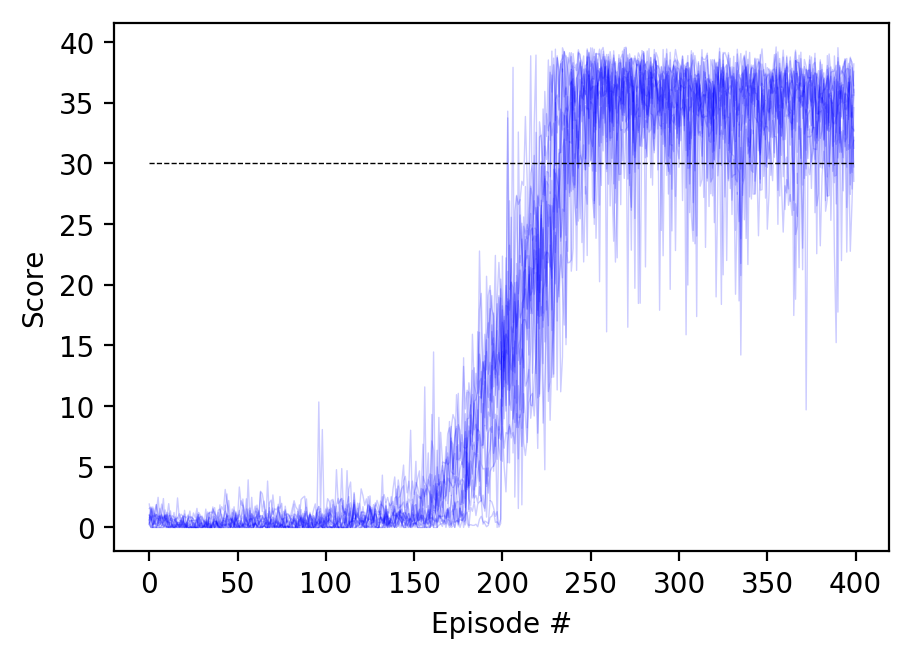

In [84]:
fig = plt.figure(figsize=(5,3.5), dpi=200)
for i in range(len(scores)):
    plt.plot(np.arange(len(scores[i])), scores[i], alpha=0.2, color='blue', linewidth=0.5)
plt.plot(np.arange(len(scores[0])), np.ones(len(scores[0])) * 30, alpha=1, color='black', linewidth=0.5, linestyle='--')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Let's find where each agent crosses the threshold for solution, as well as when the whole population does on average. We start by calculating rollin averages over 100 episodes (or all episodes so far if fewer than 100)

In [48]:
scores_matrix = np.array(scores)
scores_cumsum = np.cumsum(scores_matrix, axis = 1)
window_cumsum = np.zeros(scores_cumsum.shape)
for i in range(0, 400):
    if (i < 100):
        window_cumsum[:, i] = scores_cumsum[:, i]
    else:
        window_cumsum[:, i] = scores_cumsum[:, i] - scores_cumsum[:, i - 100]
rolling_average_divisor = np.hstack((np.arange(1, 101), 100 * np.ones((300))))
rolling_averages = np.divide(window_cumsum, rolling_average_divisor)
population_rolling_average = np.mean(rolling_averages, axis = 0)

Visualise the rolling averages.

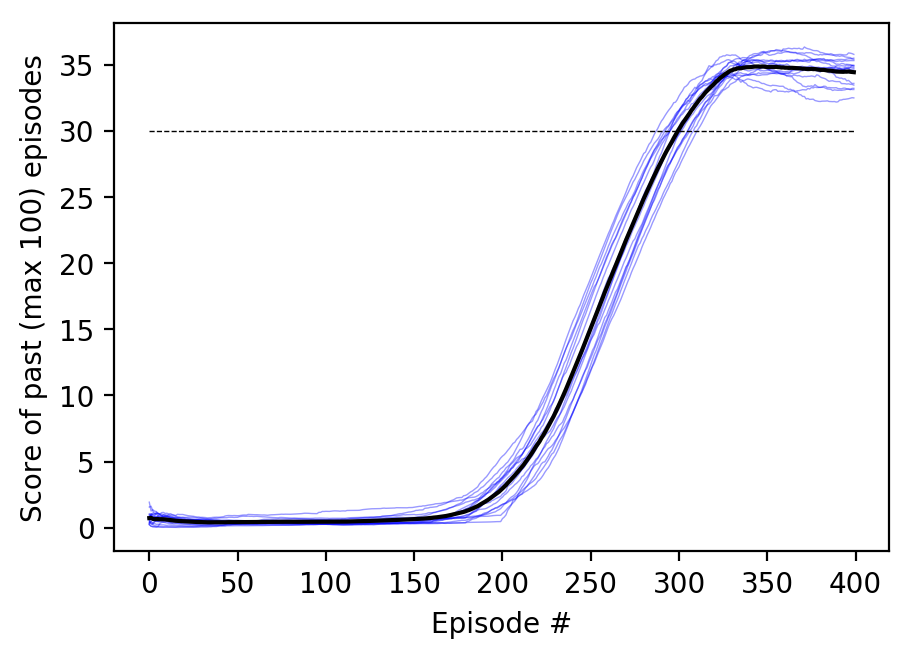

In [75]:
max_episode = len(scores[0])
fig = plt.figure(figsize=(5,3.5), dpi=200)
for i in range(len(scores)):
    plt.plot(np.arange(len(scores[i])), rolling_averages[i,:], alpha=0.4, color='blue', linewidth=0.5)
plt.plot(np.arange(max_episode), population_rolling_average, alpha=1, color='black')
plt.plot(np.arange(max_episode), np.ones(max_episode) * 30, alpha=1, color='black', linewidth=0.5, linestyle='--')
plt.ylabel('Score of past (max 100) episodes')
plt.xlabel('Episode #')
plt.show()

Find the first agent to solve the environment, and the episode when this occurred.

In [67]:
solution_times = np.argmin(np.where(rolling_averages >= 30, np.arange(0, rolling_averages.shape[1]), np.ones(rolling_averages.shape) * 1e10), axis=1)
fastest_agent = np.argmin(solution_times)
fastest_agent_solution_time = solution_times[fastest_agent] - 100
fastest_agent, fastest_agent_solution_time

(9, 188)

We find out that **agent number 9 solved the environment after 188 episodes**.

The weights of the agent that was proven successful between episodes 188 and 288 have been saved as part of the training process at episode 300. They are included in the file `agent_9_episode_300.pth` and can be loaded from there with `torch.load`.

Now let us examine the population as a whole and find out when all agents on average solve the environment.

In [83]:
np.argwhere(population_rolling_average > 30)[0][0] - 100

200

We find out that the **population of agents** taken together **reached average performance at the solution threshold after 200 episodes**.

When finished, we can close the environment.

In [28]:
env.close()

### 5. Ideas for further work

Population based training together with DDPG seems to solve the environment in a fairly robust way. However, during the early episodes, the learning results appear slow. This may be a result of the agents overfitting into a limited sample of experience early on in the training process. Additional experiments could be carried out to examine if the early learning performance is better after mitigating this either by:
- adding regularization (e.g. Dropout or L2) to the networks (the original paper uses L2 for the critic), or
- implementing a grace period where the agent first collects a sample of experience that is significantly larger than one minibatch before carrying out any training.

In this work I use the same noise process with the same parameters throughout the training. It may be more appropriate to explore more early on (more noise) and act closer to the learned approximation of optimal policy later on (less noise). It would be interesting to experiment on both a fixed noise reduction schedule, and treating the noise parameters as hyperparameters explored by the population based training procedure.

Additional changes that may improve agent performance would include experimenting with different network architectures.

Before further work on improving the learning performance, it would be useful to refactor the code into separate modules and make sure the interfaces between the different classes and functions are as convenient as possible. Additionally, it would be interesting to examine the changes made to hyperparameters during the population based training process.
